# z2z Metadata analysis

Analysis of z2z metadata

By Isthmus // Mitchell P. Krawiec-Thayer

## Import Libraries
(if you have any issues with the next cell, run `pip install -r requirements.txt` to install dependencies)

In [1]:
import isthmuslib as isli
import pandas as pd
import matplotlib.pyplot as plt
import os as os
import numpy as np

## Set parameters

In [2]:
data_file_path = os.path.join(os.path.curdir,'..','data','version_controlled')
data_file_name = 'z2z.csv'
old_fee = 0.0001 # ZEC
new_fee = 0.00001 # ZEC
transition_height = 1_080_000

## Import data

Load from file

In [3]:
df = pd.read_csv(os.path.join(data_file_path, data_file_name))

## Feature engineering

In [4]:
# Convert zatoshis to ZEC
df['fee_ZEC'] = df['fee']/1e8

#M Mark the transactions that used the standard fee (at time of inclusion in block)
# to do: replace with one-liner
buffer = list()
for row_index in range(len(df)):
    height = df['block_number'][row_index]
    fee = df['fee_ZEC'][row_index]
    if (height < transition_height) & (fee == old_fee):
        buffer.append(True)
    elif (height >= transition_height) & (fee == new_fee):
        buffer.append(True)
    else:
        buffer.append(False)
df['standard_fee'] = buffer
df.head()

,hash,version,lock_time,block_number,input_count,output_count,is_coinbase,fee,fee_ZEC,standard_fee
0,94f1ec563b081c63503766691912aa75182ea2e991fd2f...,4,0,1278214,1,0,False,1000,0.00001,True
1,f2e6897bcb708b97da945cf141468f8bf89d94606d1ad2...,4,0,1278209,1,0,False,1000,0.00001,True
2,2bd7e5f7a66b8c78dbcfafdd1681aba24630e7bc0cf045...,4,0,1278207,1,0,False,1000,0.00001,True
3,38ae545e0a5f35a428d719f4584c032b33fbded0bca9af...,4,0,1278203,1,0,False,1000,0.00001,True
4,75e8c1c9a9b4125591e5bfa70e6acebdbd900da027deca...,4,0,1278195,1,0,False,1000,0.00001,True


In [5]:
print('out of ' + str(len(df[(df['block_number']<transition_height)])) + ' pre-transition transactions, ' + str(len(df[(df['block_number']<transition_height) & (df['fee_ZEC']==old_fee)])) + ' of them used the standard fee')
print('out of ' + str(len(df[(df['block_number']>=transition_height)])) + ' pre-transition transactions, ' + str(len(df[(df['block_number']>=transition_height) & (df['fee_ZEC']==new_fee)])) + ' of them used the standard fee')
print('overall, ' + str(len(df[df['standard_fee'] == True])) + ' of ' + str(len(df)) + ' transactions used the standard fee')

out of 129717 pre-transition transactions, 104576 of them used the standard fee
out of 43152 pre-transition transactions, 39411 of them used the standard fee
overall, 143987 of 172869 transactions used the standard fee


## Data visualizations

### Histograms

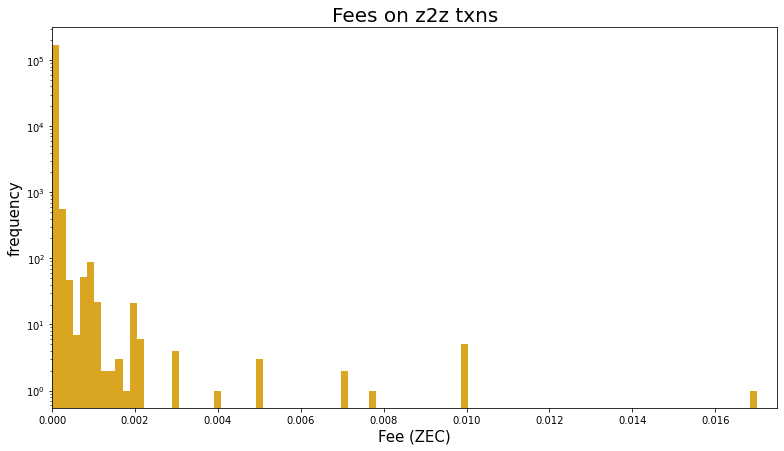

In [6]:
isli.hist(df['fee_ZEC'], xlabel='Fee (ZEC)', title='Fees on z2z txns', bins=100, yscale='log', color='goldenrod', xlim = (0,0.0175));

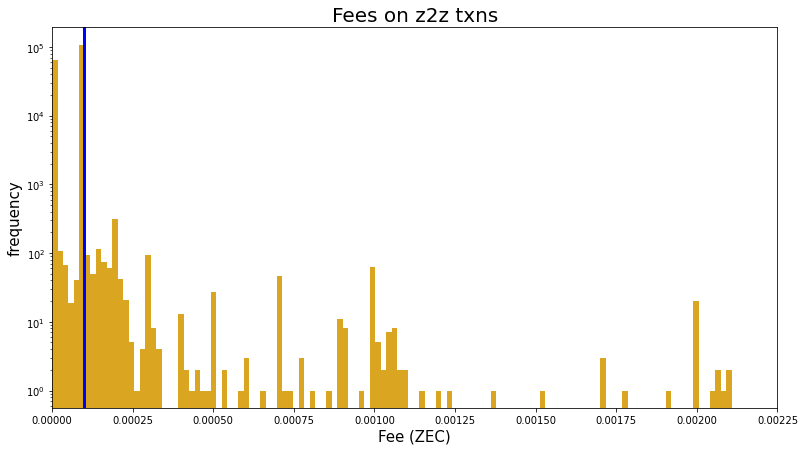

In [7]:
isli.hist(df['fee_ZEC'], xlabel='Fee (ZEC)', title='Fees on z2z txns', bins=1000, yscale='log', color='goldenrod');
plt.xlim([0,0.00225])
plt.axvline(x=0.0001, color='blue', linewidth=3);

### Scatter plots

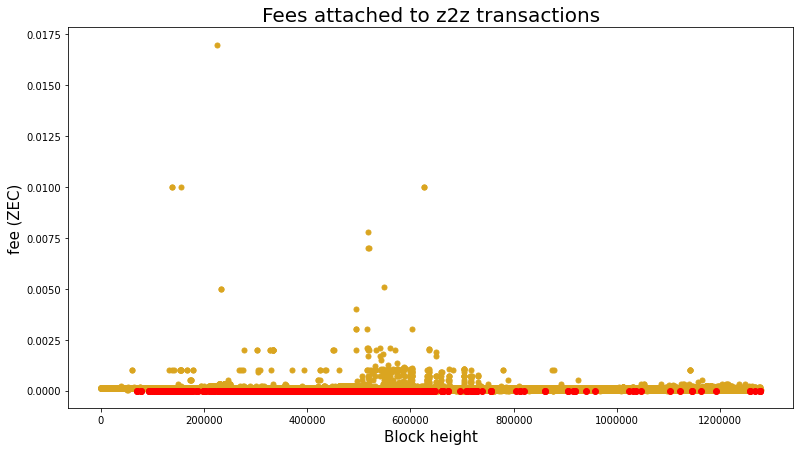

In [8]:
f = isli.scatter(df['block_number'], df['fee_ZEC'], markersize=25, xlabel='Block height', ylabel='fee (ZEC)', markercolor='goldenrod',title='Fees attached to z2z transactions');
zero_fees = df['fee'] == 0
plt.scatter(df['block_number'][zero_fees], df['fee_ZEC'][zero_fees], color='r')
plt.ticklabel_format(style='plain');

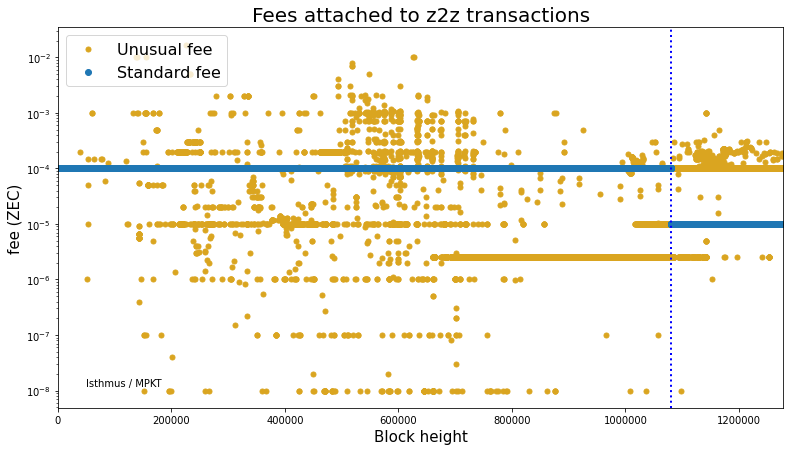

In [9]:
isli.scatter(df['block_number'], df['fee_ZEC'], markersize=25, xlabel='Block height', ylabel='fee (ZEC)', markercolor='goldenrod', yscale='log', title='Fees attached to z2z transactions');
standard_fees = df['standard_fee'] == True
plt.scatter(df['block_number'][standard_fees], df['fee_ZEC'][standard_fees])
plt.xlim((0,max(df['block_number'])))
plt.legend(('Unusual fee', 'Standard fee'), fontsize=16, loc='upper left')
plt.ticklabel_format(style='plain', axis='x')
plt.text(5e4, 1.2e-8, "Isthmus / MPKT")
plt.axvline(x = transition_height, color='blue', linewidth=2, linestyle=':');

## Statistical analysis

In [10]:
def fraction(df, value, fieldname = 'fee_ZEC'):
    return len(df[df[fieldname]==value])/len(df)

In [11]:
# Percentage of txns that used the standard fee?
round(len(df[standard_fees])/len(df)*100,2)

83.29

In [12]:
# Percentage of txns that used the standard fee since transition
round(100*len(df[(df['block_number']>=transition_height) & (df['fee_ZEC']==new_fee)]) / len(df[(df['block_number']>=transition_height)]),2 )

91.33

In [13]:
# How many non-standard were there total?
len(df) - len(df[standard_fees])

28882

In [14]:
# How many unique fee values?
s = set(df['fee_ZEC'])
print('There were ' + str(len(s)) + ' unique fee values in ' + str(len(df)) + ' z2z txns')

There were 743 unique fee values in 172869 z2z txns


In [15]:
df_counts = pd.DataFrame()
df_counts['z2z txn count'] = df.groupby(['fee']).count().sort_values(by='hash', ascending = False).hash
df_counts = df_counts.reset_index().rename_axis("ranking", axis="columns").rename(columns = {'fee':'fee (zatoshis)'})
df_counts.head(10)

ranking,fee (zatoshis),z2z txn count
0,10000,107799
1,1000,48719
2,250,12169
3,0,2257
4,20000,257
5,1,114
6,100,92
7,30000,75
8,15000,63
9,100000,59
